In [1]:
using DrWatson
@quickactivate "sst-mot-analysis"

import DrWatson: datadir, srcdir
import DrWatson: @quickactivate
include(srcdir("compare_random_samples.jl"))

using GH19, TMI, PythonCall, Revise
using CSV, DataFrames

 takes about 10 minutes
Theta_OPT-0015.nc already downloaded; use `force=true` to re-download
Theta_anom_OPT-0015.nc already downloaded; use `force=true` to re-download


In [2]:
#helper functions to check if a location is wet on two TMI grids 
surfacedepth(γ) = γ.depth[surfaceindex(γ)]
function iswetloc(loc, γ1::Grid, γ2::Grid)
    if length(loc) < 3
        max_depth = maximum([surfacedepth(γ1), surfacedepth(γ2)])
        loc3 = (loc..., max_depth)
        return (iswet(loc3,γ1) * iswet(loc3,γ2)) 
    elseif length(lo) == 3
        return (iswet(loc,γ1) * iswet(loc,γ2)) 
    end
end

iswetloc(x) = iswetloc(x, γ_lgm, γ_PI)

# Configure LGM dataset
TMIversion_lgm = "LGM_90x45x33_G14"
A_lgm, Alu_lgm, γ_lgm, TMIfile_lgm, L_lgm, B_lgm = config(TMIversion_lgm);

# Configure PI dataset
TMIversion_PI = "modern_180x90x33_GH11_GH12"
A_PI, Alu_PI, γ_PI, TMIfile_PI, L_PI, B_PI = config(TMIversion_PI);

iswetloc (generic function with 2 methods)

In [4]:
#load in OC3 core sites 
#Reference: https://pastglobalchanges.org/science/wg/former/oc3
OC3_locs_df = 1 .*  DataFrame(CSV.File(datadir("OC3_sites_positions.csv")))[:, 3:4]

OC3_lons = OC3_locs_df.var"Longitude (degE)"
OC3_lons[OC3_lons .< 0.0] .+= 360
OC3_lats = OC3_locs_df.var"Latitude (degN)"

#Make lat-lon array for OC3 core sites 
OC3_locs = Vector{Tuple{Float64, Float64}}(undef, size(OC3_locs_df, 1))
[OC3_locs[i] = (OC3_lons[i], OC3_lats[i]) for i in eachindex(OC3_locs)]

#check which exist on the TMI grids
OC3_locs = unique(OC3_locs[iswetloc.(OC3_locs)]);

### Targeted sampling. W
What if we provide locations instead of randomly generating them? 

In [5]:
Nboot = 2500
N_sample = length(OC3_locs)
OC3_locs_sampl_results  = bootstrap_PI_lgm_differences(N_sample, Nboot; locs = OC3_locs);

Form water-mass matrix A
  0.014030 seconds (1.99 k allocations: 26.437 MiB)
LU factorization of A
  0.383627 seconds (88 allocations: 305.217 MiB, 4.13% gc time)
circulation matrix L=
  0.001697 seconds (333 allocations: 26.828 KiB)
Boundary matrix B=
  0.001491 seconds (332 allocations: 26.805 KiB)
Form water-mass matrix A
  0.041694 seconds (5.23 k allocations: 118.943 MiB, 19.50% gc time)
LU factorization of A
  4.477845 seconds (88 allocations: 2.810 GiB, 0.97% gc time)
circulation matrix L=
  0.130316 seconds (8.14 M allocations: 224.520 MiB, 5.93% gc time)
Boundary matrix B=
  0.014256 seconds (6.14 k allocations: 7.270 MiB)
Form water-mass matrix A
  0.026420 seconds (5.23 k allocations: 118.943 MiB)
LU factorization of A
  4.447867 seconds (88 allocations: 2.810 GiB, 0.10% gc time)
circulation matrix L=
  0.128406 seconds (8.14 M allocations: 224.520 MiB, 5.49% gc time)
Boundary matrix B=
  0.011058 seconds (6.14 k allocations: 7.270 MiB)


Running 2500 MC trials (n=285).. 100%|███████████████████| Time: 0:05:25


dSST-TMI: 4.74410414473183
dMOT-TMI: 2.2927657013211613


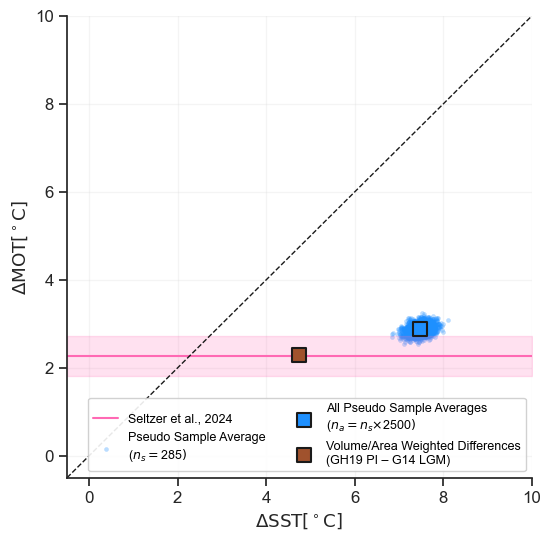

In [10]:
generate_temperature_difference_plot(
    OC3_locs_sampl_results,
    :uniform, N_sample, Nboot, plotsdir("S.LGM_PI_Temp_diff_weighted_OC3_samples.png"); xlims = (-0.5, 10)
);